This is script will figure out travel times from different runs

In [1]:
import argparse
import pandas

# declare some column names
travelTime = 'travelTime'
startTime = 'startTime'
endTime = 'endTime'
id = 'personId'
tripNumber = 'tripNo'
mode = 'mainMode'

def parse_args(args):
    parser = argparse.ArgumentParser()
    parser.add_argument('-f', '--files', nargs='+', required=True)
    parser.add_argument('-n', '--names', nargs='+', required=True)
    return parser.parse_args(args)

def read_csv(listOfFiles, listOfNames):
    
    assert(len(listOfFiles) == len(listOfNames)), 'number of files and scenario names should be equal but was: (' + str(len(listOfFiles)) + '/' + str(len(listOfNames)) + ')'
    
    result = []

    for file, name in zip(listOfFiles, listOfNames):
        scenario = pandas.read_csv(file, usecols=[id, tripNumber, startTime, endTime, mode])
        scenario.set_index([id, tripNumber], inplace=True)
        scenario.sort_index(inplace=True)
        scenario[travelTime] = scenario[endTime] - scenario[startTime]
        result.append(scenario)
    return result

In [2]:
dataFolder = "C:\\Users\\Janekdererste\\Desktop\\nemo_analysis\\"
args = parse_args([
    '-f', dataFolder + 'base-case.csv', dataFolder + 'sustainable.csv', dataFolder + 'deurbanisation-100.csv', dataFolder + 'smartCity.csv',
    '-n', 'Base Case', 'Gesund & Nachhaltig' , 'Deurbanisation', 'Smart City'
])

dataFrames = read_csv(args.files, args.names)
data = pandas.concat(dataFrames, keys=args.names, names=['RunId', id, tripNumber])
print(data.head(10))

                           startTime  endTime mainMode  travelTime
RunId     personId tripNo                                         
Base Case 54804601 0         24903.0  27398.0      car      2495.0
                   1         32565.0  34230.0      car      1665.0
                   2         34230.0  35390.0      car      1160.0
                   3         41131.0  42675.0      car      1544.0
                   4         42675.0  43419.0      car       744.0
                   5         43419.0  46989.0      car      3570.0
          54822301 0         22837.0  25171.0      car      2334.0
                   1         49188.0  51108.0      car      1920.0
                   2         55531.0  57886.0      car      2355.0
          54847601 0         21487.0  24319.0      car      2832.0


In [3]:
# select the mode and the travel time
travelTimes = data[[travelTime, mode]]

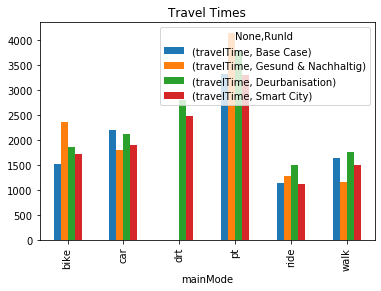

In [4]:
# group by mode and by run id
grouped = travelTimes.groupby([mode, 'RunId']).mean()
# unstack the multi-index into two columns for both run ids and then plot
grouped.unstack(level='RunId').plot.bar(title='Travel Times')

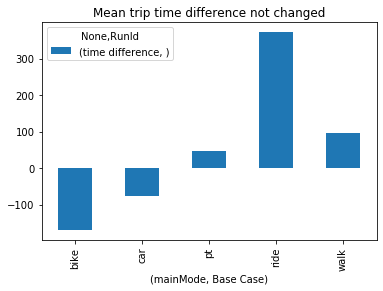

In [12]:
# compute time differences between base and scenario-case

unstacked_travel_times = travelTimes.unstack(level='RunId')
unstacked_travel_times['time difference'] = unstacked_travel_times[travelTime, 'Deurbanisation'] - unstacked_travel_times[travelTime, 'Base Case']

# select trips which have the same mode in both scenarios
is_same_mode = unstacked_travel_times[mode,'Base Case'] == unstacked_travel_times[mode, 'Deurbanisation']
differences_same_mode = unstacked_travel_times[is_same_mode]

#print(differences_same_mode)

baseCaseMainMode = differences_same_mode.xs([(mode, 'Base Case'), ('time difference','')], axis=1)
mean = baseCaseMainMode.groupby((mode, 'Base Case')).mean()
mean.plot.bar(title='Mean trip time difference not changed')

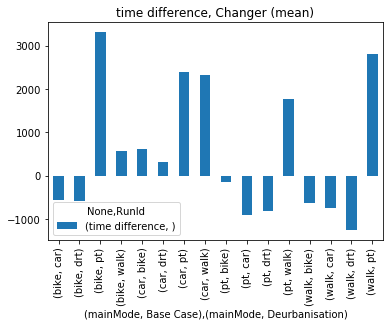

In [13]:
# select the ones which have different modes in scenario and base case
is_not_same_mode = unstacked_travel_times[mode,'Base Case'] != unstacked_travel_times[mode, 'Deurbanisation']
different_mode = unstacked_travel_times[is_not_same_mode]

#print(different_mode)

baseCaseMainMode = different_mode.xs([(mode, 'Base Case'),(mode, 'Deurbanisation'), ('time difference', '')], axis=1)
mean = baseCaseMainMode.groupby([(mode, 'Base Case'), (mode, 'Deurbanisation')]).mean()
mean.plot.bar(title='time difference, Changer (mean)')